# Analyse quality of FEI Face Database
https://fei.edu.br/~cet/facedatabase.html

In [44]:
import os
from tqdm import tqdm
images_base_addr = '/home/tmd4/FEI_face_db/'
jpeg_files = [f for f in os.listdir(images_base_addr) if '.jpg' in f]
jpeg_files.sort(key=lambda x: int(x.split('-')[0])*100 + int(x.split('-')[1].split('.')[0]))

## All angles of 1 person vs same angle for multiple people

In [45]:
jpeg_files_dict = {}
for j in jpeg_files:
    name, pose = j.split('-')
    name = int(name)
    pose = pose.split('.')[0]
    pose = int(pose)
    if pose > 11:
        continue
    if name not in jpeg_files_dict:
        jpeg_files_dict[name] = {}
    jpeg_files_dict[name][pose] = images_base_addr + j

In [46]:
# Same person multiple angles
# https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30
import imageio
with imageio.get_writer('person1_angles1to11.gif', mode='I') as writer:
    for filename in jpeg_files_dict[1].values():
        image = imageio.v2.imread(filename)
        writer.append_data(image)

<img src="person1_angles1to11.gif" width="350px" align="center">

In [48]:
# Same angle multiple people
max_angles = 2 # all 11 angles (12) takes a while + lots of space
for angle in tqdm(range(1,max_angles)):
    with imageio.get_writer(f'all_persons_angle_{angle}.gif', mode='I') as writer:
        for i in range(1,201):
            filename = jpeg_files_dict[i][angle]
            image = imageio.v2.imread(filename)
            writer.append_data(image)

100%|██████████| 1/1 [00:14<00:00, 14.95s/it]


## Amazon Rekognition API angle analysis

Investigating how accurate following is
<img src="https://miro.medium.com/v2/resize:fit:1382/format:webp/1*U4ZQ8UjzouVMRo2Fgsz7UA.png" width="350px" align="center">

In [ ]:
<img src="all_persons_angle_1.gif" width="350px" align="center">

In [4]:
import json
import pandas as pd
pose_dict = {'pitch': [], 'roll': [], 'yaw': [], 
            'pose_idx': [], 'image_addr': []}
pitch, roll, yaw = {}, {}, {}
for f in jpeg_files:
    json_file = open(images_base_addr + f.replace('.jpg', '.json'), 'r')
    faceDetail = json.load(json_file)
    json_file.close()
    if len(faceDetail['FaceDetails']) == 0:
        # print(f)
        continue

    pose = faceDetail['FaceDetails'][0]['Pose']
    p, r, y = pose['Pitch'], pose['Roll'], pose['Yaw']
    pose_idx = (f.split('-')[1].split('.')[0])
    pose_dict['pitch'].append(p)
    pose_dict['roll'].append(r)
    pose_dict['yaw'].append(y)
    pose_dict['pose_idx'].append(pose_idx)
    pose_dict['image_addr'].append(f)
    
pose_df = pd.DataFrame(pose_dict)
pose_df_filt = pose_df[pose_df['pose_idx'].map(lambda x: int(x)) <= 11]

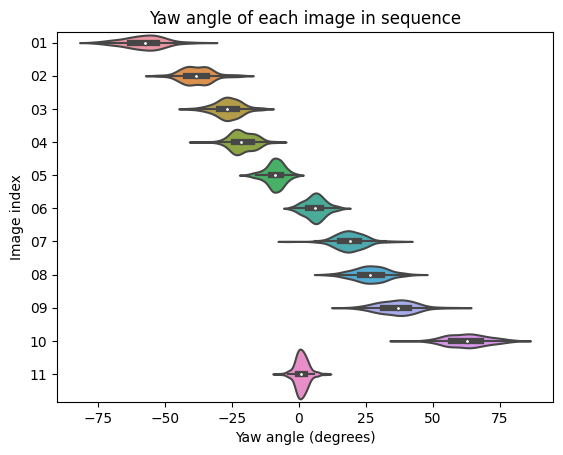

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

def violin_plot(pose_type):
    sns.violinplot(data=pose_df_filt, orient='h', x=pose_type.lower(), y='pose_idx', showmeans=True, width=1.5)
    plt.title(f'{pose_type.capitalize()} angle of each image in sequence')
    plt.xlabel(f'{pose_type.capitalize()} angle (degrees)')
    plt.ylabel('Image index')
    plt.margins(y=.008)
    plt.show()
    
violin_plot('yaw')

In [86]:
# To quickly make a scatter (no colours with plotly)
# import plotly.express as px
# fig = px.violin(data_frame=pose_df_filt, x='yaw', y='pose_idx', hover_data='image_addr')
# fig.show()

from ipywidgets import HBox, VBox
from ipywidgets import Image, Layout
import plotly.graph_objects as go

def interactive_violin_plot(pose_type):
    fig = go.FigureWidget()
    for pose_idx in pose_df_filt['pose_idx'].unique():
        pose_filter = pose_df_filt['pose_idx'] == pose_idx
        fig.add_trace(go.Violin(x=pose_df_filt[pose_filter][pose_type.lower()], line_color='black',
                                meanline_visible=True, fillcolor='lightseagreen', customdata=pose_df_filt[pose_filter]['image_addr'],
                                opacity=0.6, name=pose_idx))
    fig.update_layout({'xaxis_title': f'{pose_type.capitalize()} angle (degrees)',
                       'yaxis_title':'Image index', 
                       'title': f'Analyse {pose_type.capitalize()} angle outliers using image'})

    image_data = {}
    for img_filename in pose_df_filt['image_addr']:
        with open(images_base_addr + img_filename, "rb") as f:
            image_data[img_filename] = f.read()

    image_widget = Image(
        value=image_data['1-01.jpg'],
        layout=Layout(height='240px', width='320px')
    )

    def hover_fn(trace, points, state):
        if len(points.point_inds) < 1: return
        ind = points.point_inds[0]
        image_widget.value = image_data[trace['customdata'][ind]]

    for vplot in fig.data:
        vplot.on_hover(hover_fn)

    return VBox([fig, image_widget])
interactive_violin_plot('yaw')

    'data': [{'customdata': array(['1-01.jpg', '2-01.jpg', '3-01.jpg', '4-01.jpg…

## Roll and pitch quick analysis

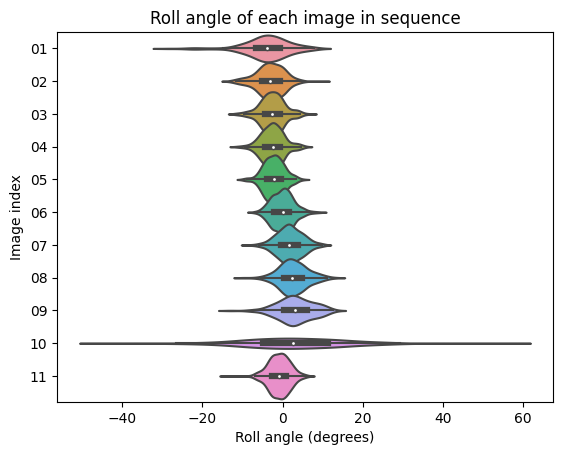

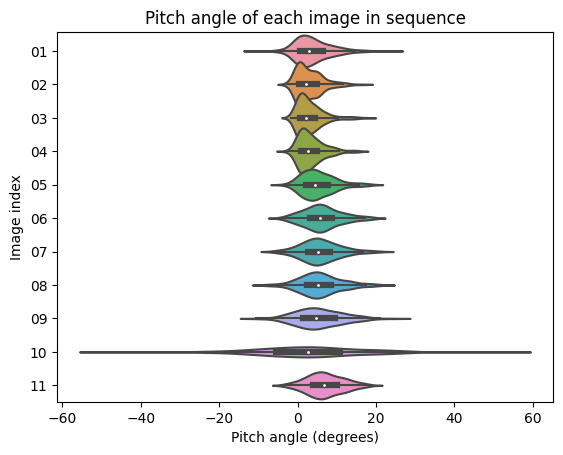

In [69]:
violin_plot('roll')
violin_plot('pitch')

In [72]:
interactive_violin_plot('roll')

    'data': [{'fillcolor': 'lightseagreen',
              'line': {'color': 'bla…

## Didn't work section

In [7]:

from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update

fig = go.Figure()
for pose_idx in pose_df_filt['pose_idx'].unique():
    pose_filter = pose_df_filt['pose_idx'] == pose_idx
    fig.add_trace(go.Violin(x=pose_df_filt[pose_filter]['yaw'], line_color='black',meanline_visible=True, fillcolor='lightseagreen', 
                            opacity=0.6, name=pose_idx))
fig.update_layout({'xaxis_title': 'Yaw angle (degrees)','yaxis_title':'Image index', 'title': 'Yaw angle of each image in sequence'})
# fig.show()
fig.update_traces(hoverinfo="none", hovertemplate=None)

app = JupyterDash(__name__)
app.layout = html.Div(
    className="container",
    children=[
        dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip-5", direction='bottom'),
    ],
)

@app.callback(
    Output("graph-tooltip-5", "show"),
    Output("graph-tooltip-5", "bbox"),
    Output("graph-tooltip-5", "children"),
    Input("graph-5", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # demo only shows the first point, but other points may also be available
    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    num = hover_data["pointNumber"]

#     im_matrix = images[num]
#     im_url = np_image_to_base64(im_matrix)
    print()
    im_url = '1-02.jpg'
    yaw_val = 30.0
    children = [
        html.Div([
            html.Img(
                src=images_base_addr + im_url,
                style={"width": "50px", 'display': 'block', 'margin': '0 auto'},
            ),
            html.P("Yaw " + str(yaw_val), style={'font-weight': 'bold'})
        ])
    ]

    return True, bbox, children

if __name__ == "__main__":
    app.run_server(mode='inline', debug=True, port=8900)
    
# ssh -N -f -L localhost:8900:localhost:8900 tmd4@adroit.princeton.edu


Dash is running on http://127.0.0.1:8900/

